In [1]:
# load data set
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
df = pd.read_csv('../labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [4]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('../train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:25<00:00, 398.57it/s]


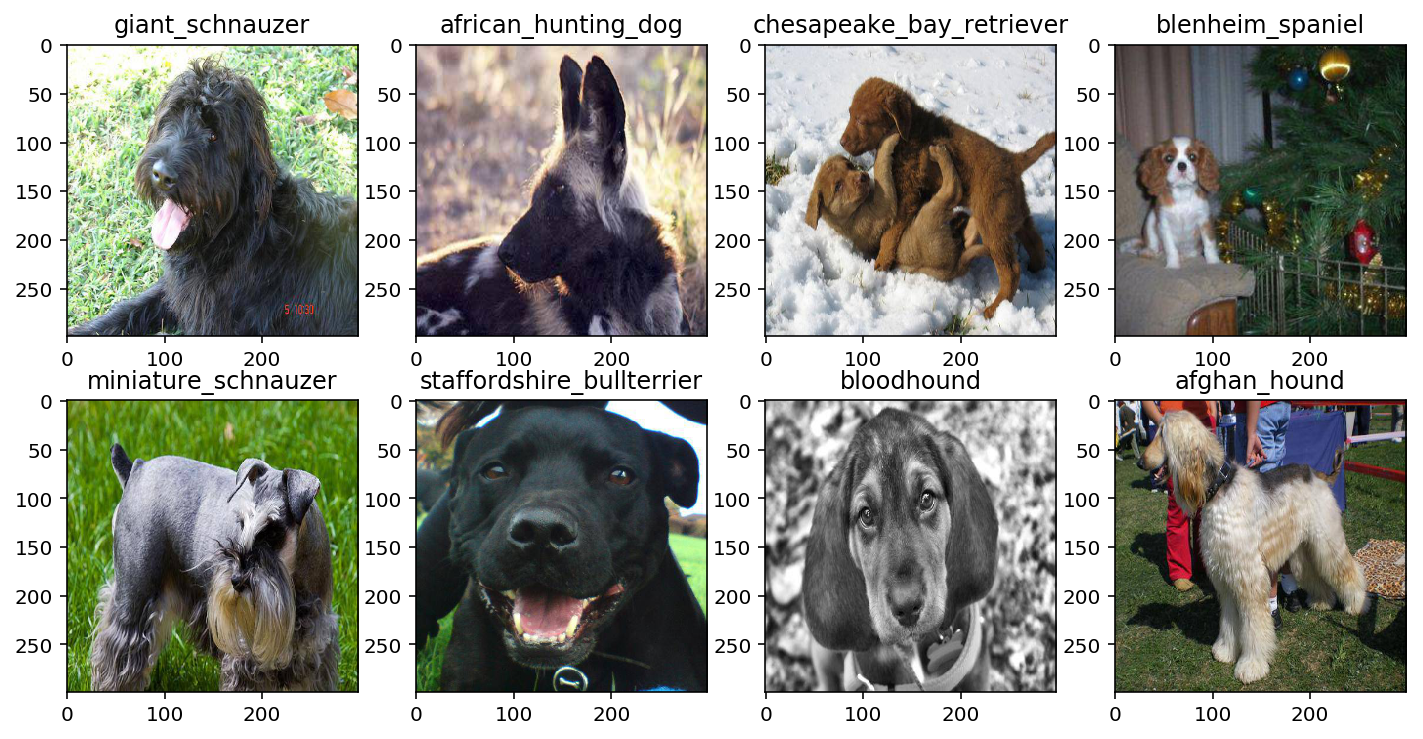

In [5]:
# visualize dataset
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

In [6]:
# select features
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [7]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [ ]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

In [20]:
# train the model
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=10, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/10
9199/9199 [==============================] - 1s - loss: 1.8725 - acc: 0.6005 - val_loss: 0.6998 - val_acc: 0.8201
Epoch 2/10
9199/9199 [==============================] - 0s - loss: 0.5864 - acc: 0.8347 - val_loss: 0.5478 - val_acc: 0.8407
Epoch 3/10
9199/9199 [==============================] - 0s - loss: 0.4407 - acc: 0.8699 - val_loss: 0.5064 - val_acc: 0.8485
Epoch 4/10
9199/9199 [==============================] - 0s - loss: 0.3588 - acc: 0.8954 - val_loss: 0.4867 - val_acc: 0.8426
Epoch 5/10
9199/9199 [==============================] - 0s - loss: 0.3063 - acc: 0.9119 - val_loss: 0.4676 - val_acc: 0.8456
Epoch 6/10
9199/9199 [==============================] - 0s - loss: 0.2636 - acc: 0.9262 - val_loss: 0.4567 - val_acc: 0.8543
Epoch 7/10
9199/9199 [==============================] - 0s - loss: 0.2272 - acc: 0.9374 - val_loss: 0.4674 - val_acc: 0.8524
Epoch 8/10
9199/9199 [==============================] - 0s - loss: 0.2031 - a

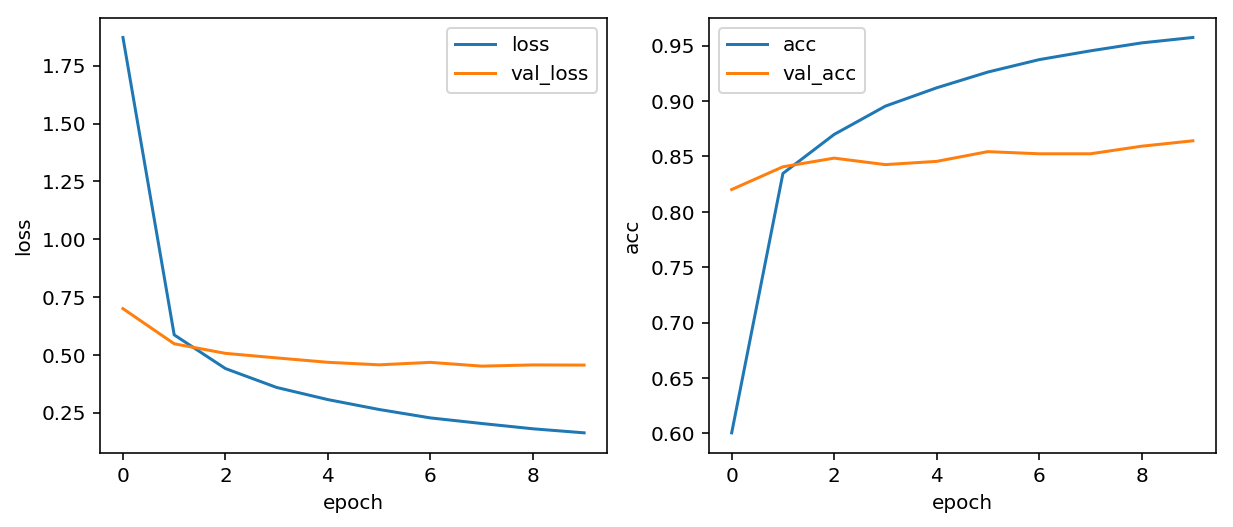

In [22]:
# visualize training process
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [23]:
# load test set
df2 = pd.read_csv('../sample_submission.csv')
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('../test/%s.jpg' % df2['id'][i]), (width, width))

100%|██████████| 10357/10357 [00:25<00:00, 401.79it/s]


In [ ]:
# select test featuers
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis=-1)

In [ ]:
# predict and save prediction
y_pred = model.predict(features_test, batch_size=128)
for b in breed:
    df2[b] = y_pred[:,class_to_num[b]]
df2.to_csv('../pred.csv', index=None)